In [300]:
import pandas as pd
import importlib
import os
from tqdm import tqdm
import numpy as np
import random

import src_dataloader.supernova_dataset as SupernovaDataset

import src_dataloader.alert_processor as AlertProcessor
import src_dataloader.data_preprocessor as DataPreprocessor
import src_dataloader.photometry_processor as PhotometryProcessor
import src_dataloader.gaussian_process as GaussianProcess
import src_dataloader.tools as tools
import src_dataloader.data_generator as DataGenerator
import src_dataloader.plot_data as plot_data
import src_dataloader.predictions as predi

importlib.reload(SupernovaDataset)
importlib.reload(AlertProcessor)
importlib.reload(DataPreprocessor)
importlib.reload(PhotometryProcessor)
importlib.reload(GaussianProcess)
importlib.reload(tools)
importlib.reload(DataGenerator)
importlib.reload(predi)
importlib.reload(plot_data)

<module 'src_dataloader.plot_data' from '/data/dev/ml_skyportal/src_dataloader/plot_data.py'>

# This notebook will help you understand the functions used from the kowalski download to a one-model train.

To start with, I'll take a single object and we'll go through the entire preprocessing pipeline step by step to help you understand each function.

For more details on each class, I've written a quick summary of each function at the top of the notebook.
You can also look at the code directly.

feel free to create a notebook for yourself where you can test each function in the same way as I do, and feel free to display the data, try to understand it and look at what it corresponds to and how it's organized.

# Documentation

# PhotometryProcessor Class

The `PhotometryProcessor` class processes and cleans photometry data, transforming, filtering, and merging it with metadata.

### Methods

#### `process_csv(name, df_bts, base_path, is_i_filter=True)`

- **Variables**: `name`, `df_bts`, `base_path`, `is_i_filter`
- **Functionality**:
  - Constructs the file path for `photometry.csv`.
  - Reads and processes the CSV file using `clean_photometry`.
- **Output**:
  - Returns a cleaned DataFrame containing photometry data for the specified object, or an empty DataFrame if the file is missing.
---

#### `clean_photometry(df, df_type, is_i_filter=True)`

- **Variables**: `df`, `df_type`, `is_i_filter`
- **Functionality**:
  - Cleans and transforms `df` using `clean_dataframe`.
  - Adds a `'type'` column from `df_type` using `obj_id` as the key.
  - Drops rows with missing `'mag'` or `'magerr'`.
- **Output**:
  - Returns a cleaned DataFrame with photometry data, including an added 'type' column.
---

#### `clean_dataframe(df, is_i_filter=True)`

- **Variables**: `df`, `is_i_filter`
- **Functionality**:
  - Renames columns (`magpsf` to `mag`, etc.).
  - Maps numerical filter IDs to strings (`ztfg`, `ztfr`, `ztfi`).
  - Removes `ztfi` filter if `is_i_filter` is `False`.
  - Converts `jd` to `mjd`.
  - Selects specific columns for output.
- **Output**:
  - Returns a transformed DataFrame with renamed columns, mapped filter names, and filtered data.
---

#### `get_first_valid_index(df, min_points=3)`

- **Variables**: `df`, `min_points`
- **Functionality**:
  - Counts occurrences of each filter (`ztfr`, `ztfg`, `ztfi`).
  - Identifies the index where `min_points` are met for any filter.
- **Output**:
  - Returns the index of the first valid entry meeting the `min_points` criterion for any filter, or `-1` if no such index exists.
---

#### `add_metadata_to_photometry(photo_df, metadata_df, is_i_filter=True)`

- **Variables**: `photo_df`, `metadata_df`, `is_i_filter`
- **Functionality**:
  - Cleans `metadata_df` using `clean_dataframe`.
  - Merges `photo_df` with cleaned `metadata_df`.
  - Fills missing `obj_id` and `type` values.
  - Removes duplicates based on `mjd` and `filter`.
  - Sorts by `mjd` and resets the index.
- **Output**:
  - Returns a merged DataFrame combining photometry and metadata, with duplicates removed and missing values filled.

# AlertProcessor Class

The `AlertProcessor` class processes astronomical alerts, handling image data and metadata extraction for each alert.

### Methods

#### `get_alerts(base_path, obj_id)`

- **Variables**: `base_path`, `obj_id`
- **Functionality**:
  - Loads alert data from a NumPy file located at the specified `base_path` and `obj_id`.
- **Output**:
  - Returns the loaded alert data as a NumPy array.
---

#### `process_image(data, normalize=True)`

- **Variables**: `data`, `normalize`
- **Functionality**:
  - Reads and decompresses image data from a gzipped FITS file.
  - Handles missing data by filling NaNs with zeros.
  - Normalizes the image if `normalize` is `True`.
  - Pads the image to a 63x63 array with small constant values.
- **Output**:
  - Returns the processed image as a 63x63 NumPy array.
---

#### `process_alert(alert)`

- **Variables**: `alert`
- **Functionality**:
  - Extracts metadata from the `alert` and converts it to a DataFrame.
  - Processes image cutouts (`science`, `template`, `difference`) using `process_image`.
  - Assembles the processed cutouts into a single 63x63x3 image.
- **Output**:
  - Returns a tuple containing the metadata DataFrame and the assembled image as a 63x63x3 NumPy array.
---

#### `get_process_alerts(obj_id, base_path)`

- **Variables**: `obj_id`, `base_path`
- **Functionality**:
  - Retrieves alerts for a given `obj_id` from the specified `base_path`.
  - Processes each alert to extract metadata and image data.
  - Compiles metadata into a single DataFrame and returns it along with the list of images.
- **Output**:
  - Returns a tuple containing the concatenated metadata DataFrame and a list of processed images (each a 63x63x3 NumPy array).
---

#### `select_alerts(data, max_alerts=30)`

- **Variables**: `data`, `max_alerts`
- **Functionality**:
  - Groups alerts by `obj_id` and sorts them by the `alerte` field.
  - Selects a maximum of `max_alerts` per `obj_id` using sampling.
  - Ensures the first and last alerts are always included.
- **Output**:
  - Returns a list of selected alerts, each containing metadata and image data.

# DataPreprocessor Class and Related Functions

The code includes the `DataPreprocessor` class and several standalone functions that handle data preprocessing tasks for photometry data, including transformation, filtering, Gaussian processing, and saving processed results.

### Methods and Functions

#### `DataPreprocessor.process_gp(photo_df)`

- **Variables**: `photo_df`
- **Functionality**:
  - Converts magnitudes to flux using `tools.Mag2Flux`.
  - Normalizes `mjd` (Modified Julian Date) values.
  - Drops duplicate rows and resets the index.
- **Output**:
  - Returns a DataFrame ready for Gaussian processing, with flux values and normalized `mjd`.
---

#### `DataPreprocessor.cut_photometry(photo_df, metadata_df, index, max_mjd=200)`

- **Variables**: `photo_df`, `metadata_df`, `index`, `max_mjd`
- **Functionality**:
  - Filters photometry data up to the current Julian Date specified by `index`.
  - Ensures that the maximum `mjd` does not exceed `max_mjd`.
- **Output**:
  - Returns the filtered DataFrame if the conditions are met, otherwise returns `None`.
---

#### `DataPreprocessor.preprocess_metadata(metadata_df)`

- **Variables**: `metadata_df`
- **Functionality**:
  - Removes duplicate entries based on `jd` (Julian Date).
  - Selects relevant metadata columns.
  - Fills missing values with `-999.0`.
- **Output**:
  - Returns a cleaned and processed metadata DataFrame with selected columns and filled missing values.
---

#### `DataPreprocessor.get_num_workers(reserved_cpus=5)`

- **Variables**: `reserved_cpus`
- **Functionality**:
  - Calculates the number of available CPU workers by subtracting `reserved_cpus` from the total CPU count.
- **Output**:
  - Returns an integer representing the number of worker processes available for parallel execution.
---

#### `remove_filter(photo_df)`

- **Variables**: `photo_df`
- **Functionality**:
  - Identifies unique filters in the photometry data.
  - Removes filters with less than 3 entries.
  - Resets the DataFrame index.
- **Output**:
  - Returns a DataFrame with filters containing at least 3 entries.
---

#### `create_heatap(data)`

- **Variables**: `data`
- **Functionality**:
  - Extracts `mjd` and flux values for different filters.
  - Creates a grid for time and wavelength.
  - Normalizes flux and flux error values.
  - Stacks normalized flux and error data into an image array.
- **Output**:
  - Returns a NumPy array representing the heatmap of normalized flux and error data, shaped as `(2, 3, len(unique_mjd))`.
---

#### `process_and_save_sample(args)`

- **Variables**: `args` (containing `sample`, `save_dir`, `kernel`, `is_i_filter`)
- **Functionality**:
  - Constructs the file path for saving the processed sample.
  - Checks if the file already exists; skips processing if it does.
  - Removes filters with insufficient data from `sample['photometry']`.
  - Processes photometry data with Gaussian processing using the specified `kernel`.
  - Creates heatmaps for processed photometry data.
  - Saves the processed data, including metadata and images, to a file in `.npy` format.
- **Output**:
  - Saves a dictionary containing processed photometry, metadata, images, and other relevant information to a `.npy` file at `save_path`.

In [186]:
BTS_PATH = 'BTS_categorized.csv'
RAW_BTS_PATH = 'BTS.csv'
KOWALSKI_PATH = 'data_kowalski'
KERNEL_PATH = 'kernel.pkl'

In [187]:
raw_bts = pd.read_csv(RAW_BTS_PATH)

In [188]:
bts_df = pd.read_csv(BTS_PATH)

In [189]:
raw_bts

,ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V
0,ZTF17aaaeqms,AT2023jkf,01:19:13.43,+31:46:26.1,2102.97,r,17.5839,-,18.001,12.004,5.997,-,-,-30.726791,0.205
1,ZTF17aaajowi,-,11:47:44.37,+14:34:10.4,1362.73,r,18.9963,-,>5.611,2.651,>2.96,-,-,70.564727,0.127
2,ZTF17aaanztg,AT2021abaw,10:04:06.59,-01:12:18.6,1501.02,r,18.3035,-,>14.737,>3,11.737,-,-,40.798120,0.210
3,ZTF17aaaocnx,AT2019dlf,06:12:54.20,+48:49:57.0,584.70,g,17.2290,-,6.213,0.803,5.41,-,-,14.194943,0.407
4,ZTF17aaaptxx,AT2023gdf,11:54:24.96,+09:36:32.8,2053.73,g,18.9437,-,>2,>2,>0,-,-,67.910221,0.079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14148,ZTF24aaguphd,AT2024ega,16:28:11.53,+47:28:46.5,2383.91,r,18.6175,-,>0,>0,>0,-,-,43.474263,0.049
14149,ZTF24aagwfly,AT2024dit,05:19:17.35,+01:19:26.3,2378.65,r,18.4562,-,>0.02,>0,>0.02,-,-,-19.733640,0.381
14150,ZTF24aagwwkr,AT2024ean,08:06:03.89,+00:37:40.3,2378.69,g,18.3445,-,>0.02,>0,>0.02,-,-,16.839103,0.093
14151,ZTF24aagzzye,AT2024ebu,16:59:07.45,+77:03:24.3,2379.87,g,18.3306,-,>0.04,>0.04,>0,-,-,32.563154,0.101


# Get one object

In [190]:
obj_id = 'ZTF20aattoch'#random.choice(bts_df['obj_id'].values)
print(obj_id)

ZTF20aattoch


In [191]:
# raw bts dataframe
raw_bts_obj = raw_bts[raw_bts['ZTFID'] == obj_id]
raw_bts_obj

,ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V
4504,ZTF20aattoch,SN2020fcu,14:24:08.92,+12:15:31.3,943.91,g,16.7794,-18.60,32.609,9.587,23.022,SN II,0.0263,63.678275,0.085


In [192]:
# bts dataframe
bts_obj = bts_df[bts_df['obj_id'] == obj_id]
bts_obj

,obj_id,type,type_step1,type_step2,type_step3a,type_step3b
4504,ZTF20aattoch,SN II,SN,SN II,Other,SN II


# Load data from kowalski folder

In [339]:
photo_df = PhotometryProcessor.PhotometryProcessor.process_csv(obj_id, bts_df, KOWALSKI_PATH)

In [194]:
metadata_df, images = AlertProcessor.AlertProcessor.get_process_alerts(obj_id, KOWALSKI_PATH)

# Sort by jd (Julian Date) and add metadata alerts not in photometry
JD (a continuous count of days and fractions since noon Universal Time on January 1, 4713 BC)

In [195]:
photo_df, metadata_df = photo_df.sort_values(by='jd'), metadata_df.sort_values(by='jd')
photo_df = PhotometryProcessor.PhotometryProcessor.add_metadata_to_photometry(photo_df, metadata_df)

In [196]:
photo_df.head()

,obj_id,jd,mjd,mag,magerr,snr,limiting_mag,filter,type
0,ZTF20aattoch,2.458937e+06,58936.437454,17.179989,0.036256,36.316837,20.598866,ztfr,SN II
1,ZTF20aattoch,2.458937e+06,58936.464190,17.001966,0.038153,63.374233,20.586430,ztfg,SN II
2,ZTF20aattoch,2.458940e+06,58939.405880,16.968599,0.099219,16.798400,17.877001,ztfr,SN II
3,ZTF20aattoch,2.458940e+06,58939.411007,17.061199,0.079613,32.217500,18.892900,ztfr,SN II
4,ZTF20aattoch,2.458940e+06,58939.411910,17.101400,0.157261,12.239000,17.547001,ztfr,SN II


### Photometry

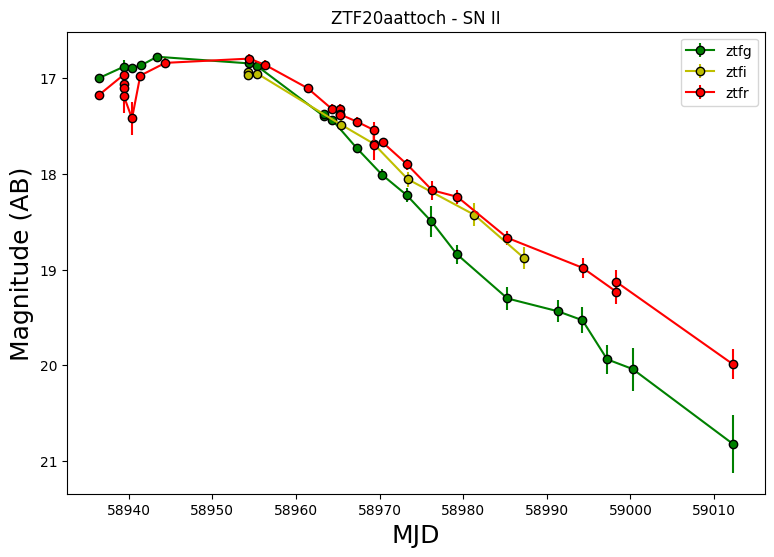

In [197]:
plot_data.plot_photometry_before(photo_df)

### Metadata

In [198]:
print(len(metadata_df))
metadata_df.head()

54


,jd,fid,pid,diffmaglim,pdiffimfilename,programpi,programid,candid,isdiffpos,tblid,...,clrmed,clrrms,neargaia,neargaiabright,maggaia,maggaiabright,exptime,drb,drbversion,obj_id
0,2.458937e+06,2,1182437453815,20.598866,ztf_20200328437454_000529_zr_c10_o_q3_scimrefd...,TESS,1,1182437453815015007,t,7,...,0.584,0.319147,47.622528,-999.0,18.408787,-999.0,30.0,0.999804,d6_m7,ZTF20aattoch
1,2.458937e+06,1,1182464183815,20.586430,ztf_20200328464178_000529_zg_c10_o_q3_scimrefd...,TESS,1,1182464183815015009,t,9,...,0.581,0.319314,47.671803,-999.0,18.408787,-999.0,30.0,0.999995,d6_m7,ZTF20aattoch
2,2.458940e+06,2,1185405873815,17.876999,ztf_20200331405833_000529_zr_c10_o_q3_scimrefd...,TESS,1,1185405873815015002,t,2,...,0.550,0.306383,47.661324,-999.0,18.408787,-999.0,30.0,0.999970,d6_m7,ZTF20aattoch
4,2.458940e+06,2,1185411000215,18.892864,ztf_20200331410926_001575_zr_c01_o_q3_scimrefd...,Kulkarni,2,1185411000215015002,t,2,...,0.600,0.324357,47.684772,-999.0,18.408787,-999.0,30.0,0.999999,d6_m7,ZTF20aattoch
3,2.458940e+06,2,1185411900215,17.546955,ztf_20200331411910_001575_zr_c01_o_q3_scimrefd...,Kulkarni,3,1185411900215015001,t,1,...,0.549,0.303825,47.821785,-999.0,18.408787,-999.0,30.0,0.999983,d6_m7,ZTF20aattoch


### Images

54
Selected index: [ 3 20 36 53]
Image number: 3


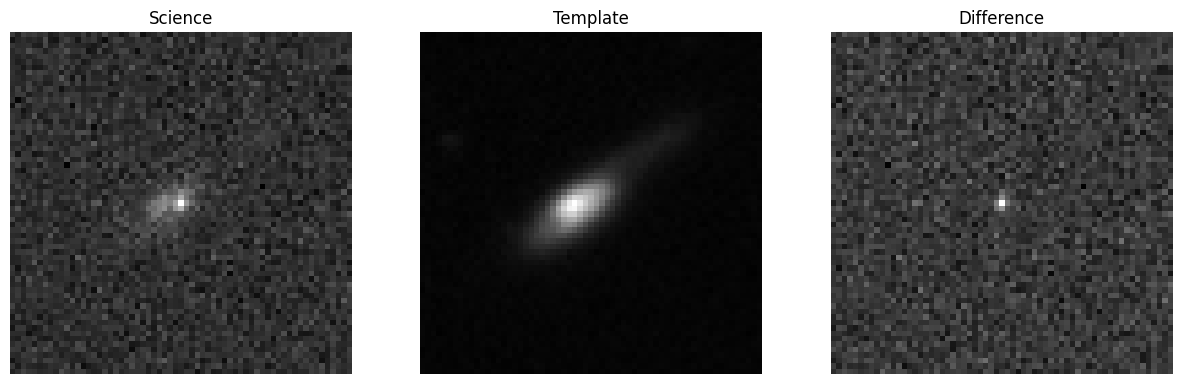

Image number: 20


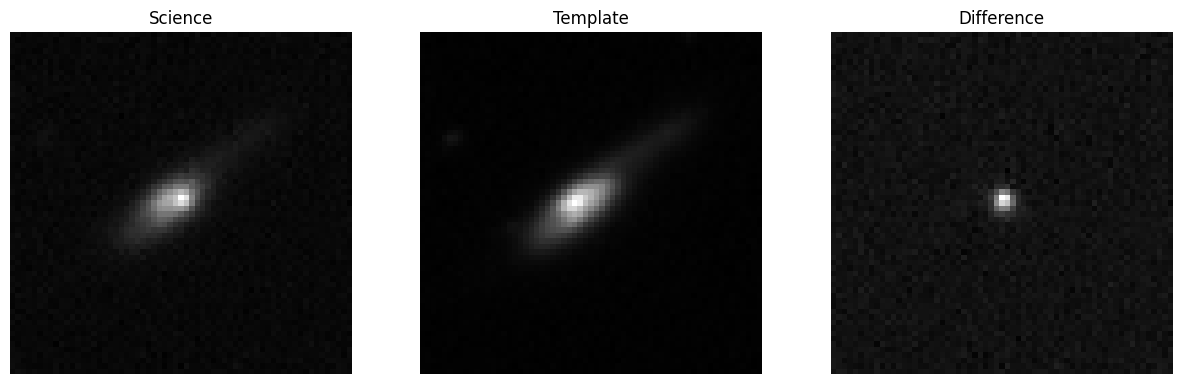

Image number: 36


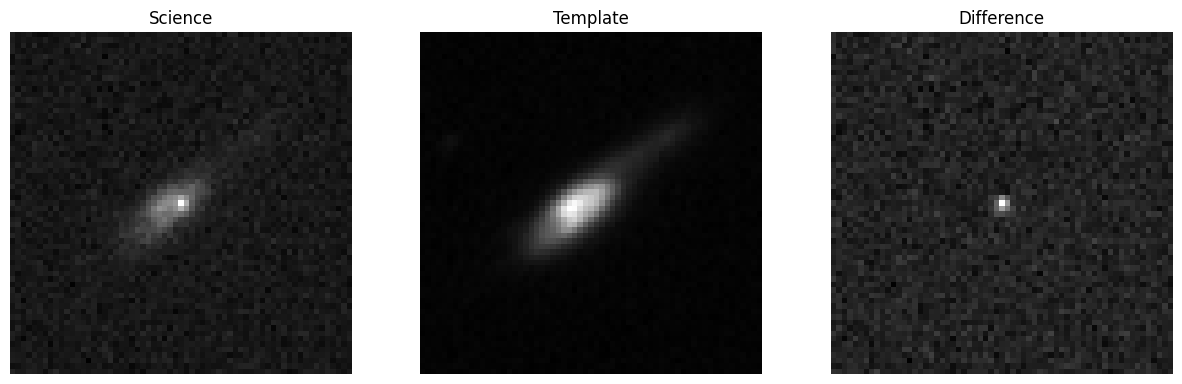

Image number: 53


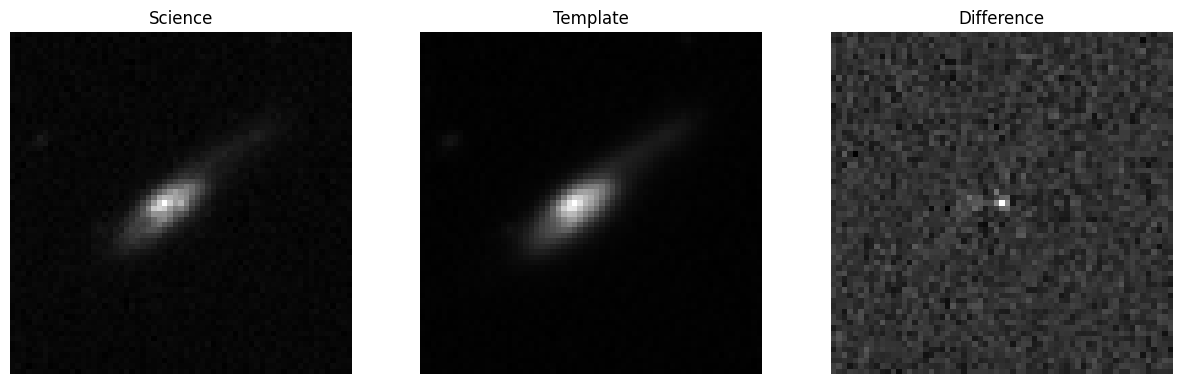

In [199]:
print(len(images))

n = 4
selected_index = np.round(np.linspace(3, len(images) - 1, n)).astype(int)
print('Selected index:', selected_index)
for i in selected_index:
    print('Image number:', i)
    plot_data.plot_image(images[i])

# Preprocess data

## Photometry

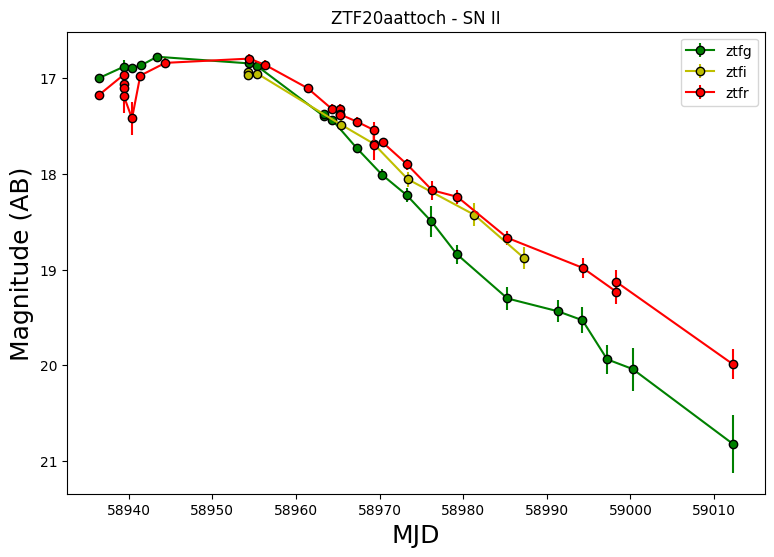

In [200]:
plot_data.plot_photometry_before(photo_df)

In [201]:
photo_df.head()

,obj_id,jd,mjd,mag,magerr,snr,limiting_mag,filter,type
0,ZTF20aattoch,2.458937e+06,58936.437454,17.179989,0.036256,36.316837,20.598866,ztfr,SN II
1,ZTF20aattoch,2.458937e+06,58936.464190,17.001966,0.038153,63.374233,20.586430,ztfg,SN II
2,ZTF20aattoch,2.458940e+06,58939.405880,16.968599,0.099219,16.798400,17.877001,ztfr,SN II
3,ZTF20aattoch,2.458940e+06,58939.411007,17.061199,0.079613,32.217500,18.892900,ztfr,SN II
4,ZTF20aattoch,2.458940e+06,58939.411910,17.101400,0.157261,12.239000,17.547001,ztfr,SN II


In [342]:
photo_df_process = DataPreprocessor.DataPreprocessor.process_gp(photo_df)
photo_df_process.head()

,obj_id,mjd,flux,flux_error,filter,type,jd
0,ZTF20aattoch,0.000000,487.528353,16.280039,ztfr,SN II,2.458937e+06
1,ZTF20aattoch,0.026736,574.380486,20.183852,ztfg,SN II,2.458937e+06
2,ZTF20aattoch,2.968426,592.325285,54.129100,ztfr,SN II,2.458940e+06
3,ZTF20aattoch,2.973553,543.901585,39.882282,ztfr,SN II,2.458940e+06
4,ZTF20aattoch,2.978125,485.780040,82.349433,ztfr,SN II,2.458940e+06


In [343]:
photo_df_process

,obj_id,mjd,flux,flux_error,filter,type,jd
0,ZTF20aattoch,0.000000,487.528353,16.280039,ztfr,SN II,2.458937e+06
1,ZTF20aattoch,0.026736,574.380486,20.183852,ztfg,SN II,2.458937e+06
2,ZTF20aattoch,2.968426,592.325285,54.129100,ztfr,SN II,2.458940e+06
3,ZTF20aattoch,2.973553,543.901585,39.882282,ztfr,SN II,2.458940e+06
4,ZTF20aattoch,2.978125,485.780040,82.349433,ztfr,SN II,2.458940e+06
5,ZTF20aattoch,3.019410,641.209757,41.742502,ztfg,SN II,2.458940e+06
6,ZTF20aattoch,3.941238,633.403043,22.960898,ztfg,SN II,2.458941e+06
7,ZTF20aattoch,3.978669,389.654848,61.164478,ztfr,SN II,2.458941e+06
8,ZTF20aattoch,4.964479,588.246879,21.183116,ztfr,SN II,2.458942e+06
9,ZTF20aattoch,5.041551,648.694327,22.998396,ztfg,SN II,2.458942e+06


In [203]:
start_index = PhotometryProcessor.PhotometryProcessor.get_first_valid_index(photo_df_process)
print('Start index:', start_index)

Start index: 3


From the 3rd alert, we have at least 3 points in the red filter

Photometry at index: 3


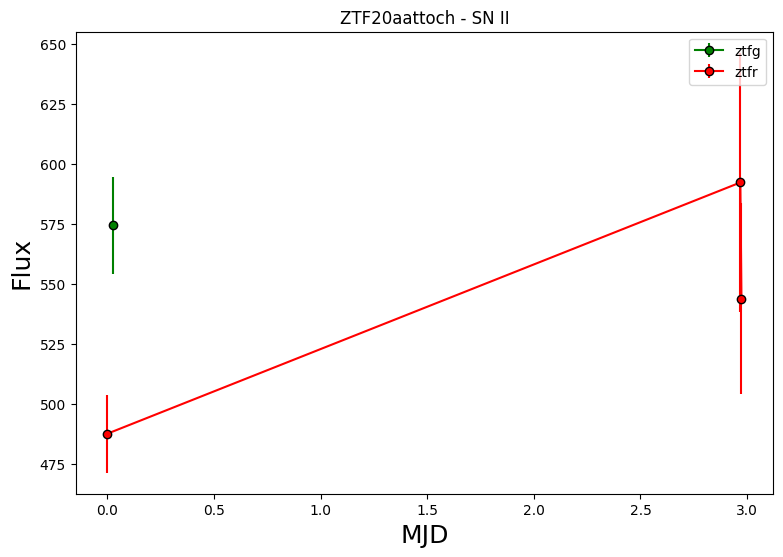

Photometry at index: 20


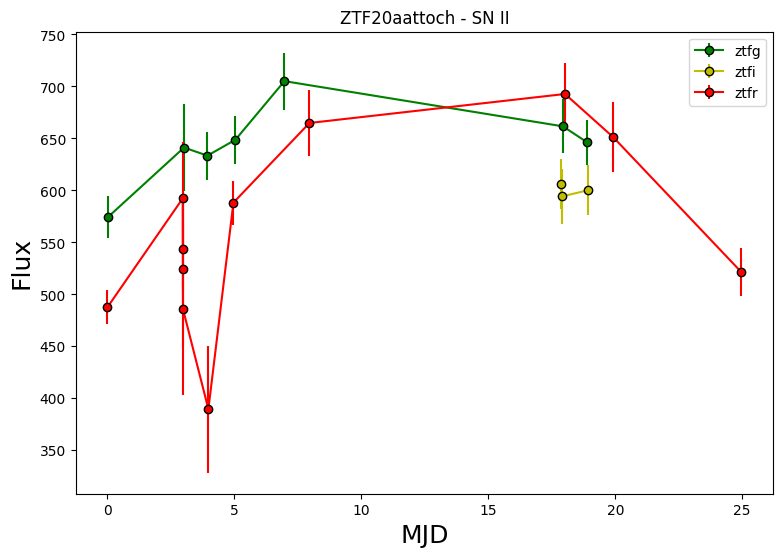

Photometry at index: 36


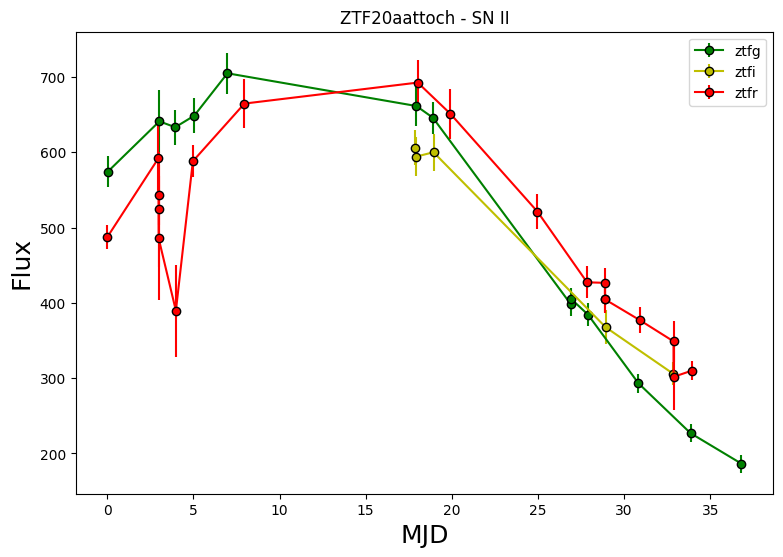

Photometry at index: 53


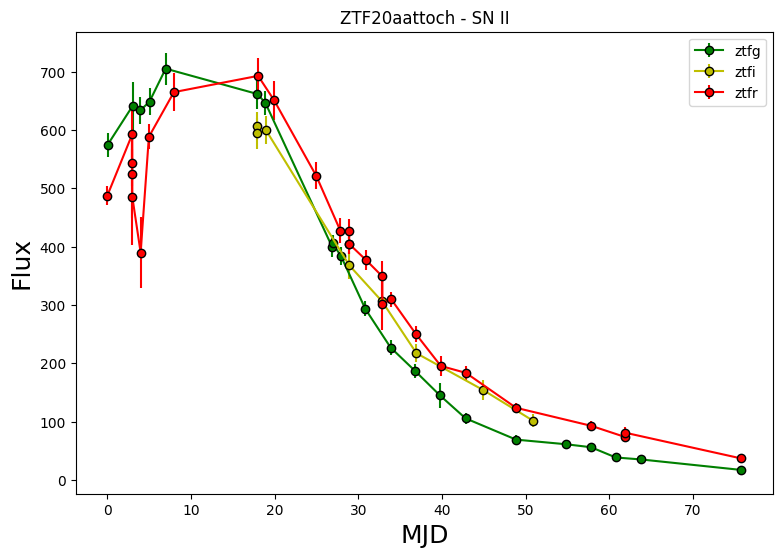

In [204]:
for i in selected_index:
    print('Photometry at index:', i)
    photo_ready = DataPreprocessor.DataPreprocessor.cut_photometry(photo_df_process, metadata_df, i)
    plot_data.plot_photometry_before(photo_ready)

# Gaussian process

In [205]:
import pickle
with open('kernel.pkl', 'rb') as file:
    kernel = pickle.load(file)

In [206]:
# If there are no points in a filter, the filter column does not exist, I create it with only 0
def complete_filter(gp_final):
    columns = ['flux_ztfg', 'flux_error_ztfg', 'flux_ztfr', 'flux_error_ztfr', 'flux_ztfi', 'flux_error_ztfi']
    
    for col in columns:
        if col not in gp_final.columns:
            gp_final[col] = 0.

    return gp_final

In [207]:
for i in selected_index:
    print('Photometry preprocess at index:', i)
    photo_ready = DataPreprocessor.DataPreprocessor.cut_photometry(photo_df_process, metadata_df, i)
    gp_final = GaussianProcess.process_gaussian(photo_ready, kernel, number_gp=200)

    gp_final = complete_filter(gp_final)
    plot_data.plot_gp(photo_ready, gp_final)

Photometry preprocess at index: 3


Photometry preprocess at index: 20


Photometry preprocess at index: 36


Photometry preprocess at index: 53


In [208]:
gp_final

,mjd,flux_ztfg,flux_ztfi,flux_ztfr,flux_error_ztfg,flux_error_ztfi,flux_error_ztfr,type,obj_id
0,0.000000,571.774639,426.627308,489.098194,17.049575,61.868632,14.448006,SN II,ZTF20aattoch
1,0.380881,578.487100,432.753215,495.842504,16.033065,61.030330,13.662768,SN II,ZTF20aattoch
2,0.761761,585.173604,438.942799,502.700177,15.203051,60.225685,13.126909,SN II,ZTF20aattoch
3,1.142642,591.828806,445.191127,509.669592,14.525684,59.451637,12.789985,SN II,ZTF20aattoch
4,1.523523,598.446365,451.492511,516.749456,13.967998,58.704890,12.600920,SN II,ZTF20aattoch
...,...,...,...,...,...,...,...,...,...
195,74.271732,18.979250,42.332367,40.051559,10.192879,60.691107,11.087328,SN II,ZTF20aattoch
196,74.652613,18.491404,41.604178,39.197259,8.393522,61.039630,9.167703,SN II,ZTF20aattoch
197,75.033493,18.012720,40.883528,38.357279,6.641084,61.437349,7.316861,SN II,ZTF20aattoch
198,75.414374,17.543816,40.170516,37.531334,5.231919,61.889719,5.813406,SN II,ZTF20aattoch


In [209]:
# print shape
print('Shape:', gp_final.shape)

Shape: (200, 9)


At the end we have 200 points regularly sampled for each filter on their light curves

It is important because it allows us to have for each object, samples in the dataset that have the same dimensions '(200, 9)'

## Metadata

In [210]:
metadata_df.head()

,jd,fid,pid,diffmaglim,pdiffimfilename,programpi,programid,candid,isdiffpos,tblid,...,clrmed,clrrms,neargaia,neargaiabright,maggaia,maggaiabright,exptime,drb,drbversion,obj_id
0,2.458937e+06,2,1182437453815,20.598866,ztf_20200328437454_000529_zr_c10_o_q3_scimrefd...,TESS,1,1182437453815015007,t,7,...,0.584,0.319147,47.622528,-999.0,18.408787,-999.0,30.0,0.999804,d6_m7,ZTF20aattoch
1,2.458937e+06,1,1182464183815,20.586430,ztf_20200328464178_000529_zg_c10_o_q3_scimrefd...,TESS,1,1182464183815015009,t,9,...,0.581,0.319314,47.671803,-999.0,18.408787,-999.0,30.0,0.999995,d6_m7,ZTF20aattoch
2,2.458940e+06,2,1185405873815,17.876999,ztf_20200331405833_000529_zr_c10_o_q3_scimrefd...,TESS,1,1185405873815015002,t,2,...,0.550,0.306383,47.661324,-999.0,18.408787,-999.0,30.0,0.999970,d6_m7,ZTF20aattoch
4,2.458940e+06,2,1185411000215,18.892864,ztf_20200331410926_001575_zr_c01_o_q3_scimrefd...,Kulkarni,2,1185411000215015002,t,2,...,0.600,0.324357,47.684772,-999.0,18.408787,-999.0,30.0,0.999999,d6_m7,ZTF20aattoch
3,2.458940e+06,2,1185411900215,17.546955,ztf_20200331411910_001575_zr_c01_o_q3_scimrefd...,Kulkarni,3,1185411900215015001,t,1,...,0.549,0.303825,47.821785,-999.0,18.408787,-999.0,30.0,0.999983,d6_m7,ZTF20aattoch


In [211]:
metadata_df_processed = DataPreprocessor.DataPreprocessor.preprocess_metadata(metadata_df)
metadata_df_processed.head()

,sgscore1,sgscore2,distpsnr1,distpsnr2,ra,dec,nmtchps,sharpnr,scorr,sky,jd
0,0.5,0.10678,2.685452,3.092980,216.037162,12.258690,7,0.621,36.316837,0.127387,2.458937e+06
1,0.5,0.10678,2.609935,3.076932,216.037169,12.258714,7,0.701,63.374233,-0.077258,2.458937e+06
2,0.5,0.10678,2.656650,3.132662,216.037151,12.258695,7,0.621,16.798386,-0.354267,2.458940e+06
4,0.5,0.10678,2.601785,3.093333,216.037165,12.258715,7,0.270,32.217499,0.053827,2.458940e+06
3,0.5,0.10678,2.479877,3.203524,216.037137,12.258742,7,0.270,12.238993,0.125636,2.458940e+06


Here I just select the most interesting columns for the classification, I use the same columns as for the BTSBot.

But in the BTSBot, they have columns that describe the photometry, as we use the photometry directly, we do not need these columns.

## Images

The metadata and the images have the same index. That is, line 10 of the metadata corresponds to the image at index 10. 

We must be careful if we take out the metadata or if we remove lines and keep the indexes, we lose the indexes which can be a problem because we cannot find the correct image associated with this alert.

# Preprocess all the data

## The problem of unbalanced classes

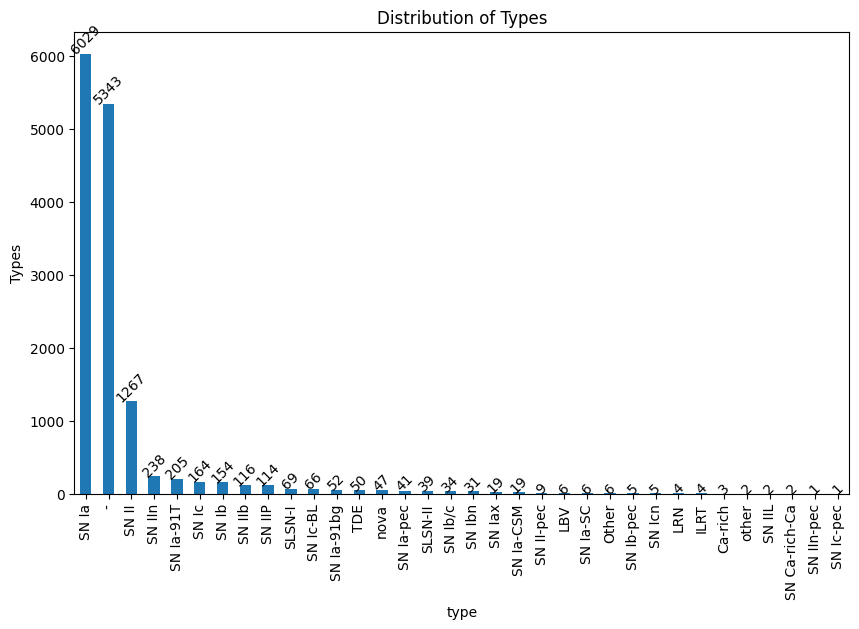

In [212]:
plot_data.plot_types_distributions(raw_bts)

To try and create the most balanced dataset possible, I preprocess the data gradually.

As a reminder, each object alert becomes a sample in our dataset.
(To avoid the model overfitting on some objects with hundreds of alerts compared to others with only a few dozen, I keep a maximum of 30 alerts).

Here's the number of objects we'll classify according to each step in our taxonomy

In [213]:
tools.print_types(bts_df)

type_step1
SN       8688
Other    5465
Name: count, dtype: int64
type_step2
SN I     6831
Other    5575
SN II    1747
Name: count, dtype: int64
type_step3a
Other      7322
SN Ia      6371
SN Ib/c     460
Name: count, dtype: int64
type_step3b
Other       12406
SN II        1392
SN IIn/b      355
Name: count, dtype: int64


To not have to preprocess everything at once (because the Gaussian process is quite long, even though I've created a function that parallelizes it), you can build the dataset gradually to make sure you have roughly the same number of alerts per class.

Let's start with this categorized dataframe. I'll just convert the labels from strings to int so that the lables can be used for training.

In [214]:
df_bts = pd.read_csv(BTS_PATH)

labels_step1 = ['Other', 'SN']
labels_step2 = ['SN I', 'SN II', 'Other']
labels_step3a = ['SN Ia', 'SN Ib/c', 'Other']
labels_step3b = ['SN II', 'SN IIn/b', 'Other']

df_bts['type_step1'] = df_bts['type_step1'].apply(lambda x: labels_step1.index(x))
df_bts['type_step2'] = df_bts['type_step2'].apply(lambda x: labels_step2.index(x))
df_bts['type_step3a'] = df_bts['type_step3a'].apply(lambda x: labels_step3a.index(x))
df_bts['type_step3b'] = df_bts['type_step3b'].apply(lambda x: labels_step3b.index(x))

tools.print_types(df_bts)

type_step1
1    8688
0    5465
Name: count, dtype: int64
type_step2
0    6831
2    5575
1    1747
Name: count, dtype: int64
type_step3a
2    7322
0    6371
1     460
Name: count, dtype: int64
type_step3b
2    12406
0     1392
1      355
Name: count, dtype: int64


In [283]:
res_df = tools.get_data(df_bts, n=40, factor_other=4)
tools.print_types(res_df)
print(len(res_df))

type_step1
1    160
0    160
Name: count, dtype: int64
type_step2
2    160
0     80
1     80
Name: count, dtype: int64
type_step3a
2    240
0     40
1     40
Name: count, dtype: int64
type_step3b
2    240
0     40
1     40
Name: count, dtype: int64
320


Here I'm taking 40 objects per class. Most of the time, there are more alerts in objects classified as SN than in Other objects. So I multiply the number of objects I take for the Others.

# Creation of the dataset

Data is pretty heavy, so you can have a lot of it if you preprocess a lot of objects.

To avoid saving everything in a variable and using all the ram of our computer.

I prefer to preprocess each alert and save them.
I then use a class that creates a data generator inherited from the Keras class. This class directly loads the preprocess alerts and creates mixed batches ready for training.

I send this class the dataframe containing the labels for each step and the selected obj_id.

In [284]:
res_df.head()

,obj_id,type,type_step1,type_step2,type_step3a,type_step3b
5582,ZTF20abyvtds,SN Ia,1,0,0,2
9451,ZTF22aadfrjm,SN Ia,1,0,0,2
4222,ZTF20aakzezp,SN Ia,1,0,0,2
3649,ZTF19acudiph,SN Ia,1,0,0,2
12082,ZTF23aaelwoi,SN Ia,1,0,0,2


In [285]:
dataset = SupernovaDataset.SupernovaDataset('data_test', base_path=KOWALSKI_PATH, kernel_path=KERNEL_PATH, is_i_filter=True)

preprocess_data allows you to perform all the functions described above and load them into a dictionary as I showed you this morning.

In [286]:
dataset.preprocess_data(res_df, KOWALSKI_PATH, is_prediction=False)
len(dataset)

Loading data:  68%|██████▊   | 216/320 [00:34<00:06, 15.13it/s]

Error processing ZTF21aalcrjh at index 7013: "['mag', 'magerr', 'snr'] not in index"


Loading data:  79%|███████▉  | 252/320 [00:37<00:08,  8.31it/s]

Error processing ZTF23aahtiax at index 12224: 'jd'


Loading data: 100%|██████████| 320/320 [00:45<00:00,  7.10it/s]


4184

preprocess_and_save allows you to perform the gaussian process for each alert and save them in a numpy file with the preprocess photometry, images, metadata and labels for each step.

In [287]:
dataset.preprocess_and_save()

Preprocessing: 100%|██████████| 4184/4184 [07:18<00:00,  9.54it/s]  


# Train

This function creates a dataframe with the name of each file from the folder name.

In [294]:
step = 'type_step1'

data_df = tools.create_df_from_file(BTS_PATH, 'data_test')
tools.print_types(data_df, columns=['type_step1'])

type_step1
SN       3720
Other    1932
Name: count, dtype: int64


In [295]:
data_df.head()

,name,file,type_step1,type_step2,type_step3a,type_step3b
0,ZTF17aabhmby,ZTF17aabhmby_alert_2.npy,Other,Other,Other,Other
1,ZTF17aabhmby,ZTF17aabhmby_alert_3.npy,Other,Other,Other,Other
2,ZTF17aabhmby,ZTF17aabhmby_alert_4.npy,Other,Other,Other,Other
3,ZTF17aabhmby,ZTF17aabhmby_alert_5.npy,Other,Other,Other,Other
4,ZTF17aabhmby,ZTF17aabhmby_alert_6.npy,Other,Other,Other,Other


In [296]:
def plot_df(data_df, nb_max=10):
    data_df = data_df.sort_values('file')
    data_df = data_df.drop_duplicates(subset='name', keep='last')
    data_df = data_df.sample(frac=1).reset_index(drop=True)

    nb = len(data_df)
    if nb_max < nb:
        nb = nb_max

    for i in range(nb):
        obj_id = data_df.iloc[i]['name']
        alerte = int(data_df.iloc[i]['file'].split('_')[-1].split('.')[0])
        type_obj = data_df.iloc[i][step]
        plot_data.plot_photometry(obj_id, alerte=None, type_obj=type_obj)

In [291]:
# Plot some data if you want

#plot_df(data_df, 5)

From the dataframe, the aim here is to split in train and validation using the file names.
The aim is to avoid having alerts from the same object in train and validation. At the end of this function, there are asserts to verify this.

In [297]:
train_files, val_files, class_weights = tools.split_and_compute_class_weights(data_df, step, verbose=True)
print('Train files:', train_files)

type_step1
SN       2923
Other    1520
Name: count, dtype: int64
type_step1
SN       797
Other    412
Name: count, dtype: int64
Train files: ['ZTF17aabhmby_alert_2.npy', 'ZTF17aabhmby_alert_3.npy', 'ZTF17aabhmby_alert_4.npy', 'ZTF17aabhmby_alert_5.npy', 'ZTF17aabhmby_alert_6.npy', 'ZTF18aaanaev_alert_10.npy', 'ZTF18aaanaev_alert_11.npy', 'ZTF18aaanaev_alert_4.npy', 'ZTF18aaanaev_alert_5.npy', 'ZTF18aaanaev_alert_6.npy', 'ZTF18aaanaev_alert_7.npy', 'ZTF18aaanaev_alert_8.npy', 'ZTF18aaanaev_alert_9.npy', 'ZTF18aalpdyt_alert_2.npy', 'ZTF18aalpdyt_alert_3.npy', 'ZTF18aalpdyt_alert_4.npy', 'ZTF18aalpdyt_alert_5.npy', 'ZTF18aalpdyt_alert_6.npy', 'ZTF18aalpdyt_alert_7.npy', 'ZTF18abgmmso_alert_2.npy', 'ZTF18acueupj_alert_3.npy', 'ZTF18acueupj_alert_4.npy', 'ZTF18acueupj_alert_5.npy', 'ZTF18acueupj_alert_6.npy', 'ZTF18adbdhwh_alert_3.npy', 'ZTF18adbdhwh_alert_4.npy', 'ZTF18adbdhwh_alert_5.npy', 'ZTF18adbdhwh_alert_6.npy', 'ZTF18adbdhwh_alert_7.npy', 'ZTF18adbdhwh_alert_8.npy', 'ZTF18adbdhwh_al

We can now use the class Datagenerator to create a datagenerator ready for training.

In [301]:
batch_size = 32

DATA_PATH = 'data_test'

train_generator = DataGenerator.DataGenerator(DATA_PATH, step=step, batch_size=batch_size, shuffle=True, file_list=train_files)
val_generator = DataGenerator.DataGenerator(DATA_PATH, step=step, batch_size=batch_size, shuffle=False, file_list=val_files)

The get item returns the data and associated label.
Data is a list of the 3 data items, data[0] the photometry, data[1] the metadata and data[2] the images.

In [302]:
data, labels = train_generator.__getitem__(0)

In [303]:
print('Shape of the photometry:', data[0].shape)
print('Shape of the metadata:', data[1].shape)
print('Shape of the images:', data[2].shape)

Shape of the photometry: (32, 200, 4)
Shape of the metadata: (32, 10)
Shape of the images: (32, 63, 63, 3)


# Try a first train

From now, you can train any model you like on the data.
We'll do an example with a simple convolutional model using images only.

So that the model returns just the images, I'll just comment out the other output in the datagenerator class.

In [304]:
class DataGeneratorImage(tf.keras.utils.Sequence):
    def __init__(self, preprocessed_path, step, batch_size=32, shuffle=True, file_list=None, **kwargs):
        super().__init__(**kwargs)
        self.preprocessed_path = preprocessed_path
        self.step = step
        self.batch_size = batch_size
        self.shuffle = shuffle
        if file_list is not None:
            self.data_files = file_list
        else:
            self.data_files = [f for f in os.listdir(preprocessed_path) if f.endswith('.npy')]
        
        self.indexes = np.arange(len(self.data_files))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.data_files) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = [self._load_data(self.data_files[i]) for i in batch_indexes]
        
        batch_data = [data for data in batch_data if data is not None]

        if not batch_data:  
            return np.array([]), np.array([])
        
        batch_x, batch_y = zip(*batch_data)

        #batch_x = tuple(tf.convert_to_tensor(item) for item in zip(*batch_x))
        batch_x = tf.convert_to_tensor(batch_x)
        batch_y = tf.convert_to_tensor(batch_y)
        
        return batch_x, batch_y

    def _load_data(self, filename):
        file_path = os.path.join(self.preprocessed_path, filename)
        sample = np.load(file_path, allow_pickle=True).item()

        # X = (sample['photometry'], sample['metadata'].to_numpy(), sample['images'])
        X = sample['images']
        y = sample[self.step]

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [305]:
batch_size = 32

DATA_PATH = 'data_test'

train_generator = DataGeneratorImage(DATA_PATH, step=step, batch_size=batch_size, shuffle=True, file_list=train_files)
val_generator = DataGeneratorImage(DATA_PATH, step=step, batch_size=batch_size, shuffle=False, file_list=val_files)

data, labels = train_generator.__getitem__(0)

In [306]:
data.shape

TensorShape([32, 63, 63, 3])

In [307]:
import tensorflow as tf
from tensorflow.keras import layers, models

class ImageProcessor(tf.keras.layers.Layer):
    def __init__(self):
        super(ImageProcessor, self).__init__()
        self.conv1 = layers.Conv2D(32, (5, 5), activation='relu', padding="same")
        self.conv2 = layers.Conv2D(32, (5, 5), activation='relu', padding="same")
        self.pool1 = layers.MaxPooling2D(pool_size=(2, 2))
        self.drop1 = layers.Dropout(0.50)
        self.conv3 = layers.Conv2D(64, (5, 5), activation='relu', padding="same")
        self.conv4 = layers.Conv2D(64, (5, 5), activation='relu', padding="same")
        self.pool2 = layers.MaxPooling2D(pool_size=(4, 4))
        self.drop2 = layers.Dropout(0.55)
        self.flatten = layers.Flatten()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.drop1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.drop2(x)
        return self.flatten(x)

def create_model(input_shape=(63, 63, 3)):
    inputs = layers.Input(shape=input_shape)
    
    # Use the ImageProcessor layer
    x = ImageProcessor()(inputs)

    # Fully connected layers for classification
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary classification
    
    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

model = create_model()

model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 63, 63, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ image_processor_1               │ (None, 3136)           │       181,792 │
│ (ImageProcessor)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 583,457 (2.23 MB)

 Trainable params: 583,457 (2.23 MB)

 Non-trainable params: 0 (0.00 B)

Add some callbacks

In [310]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

DIR_CHECKPOINTS = 'checkpoints_test/'

checkpoint_path = DIR_CHECKPOINTS + 'simple_image_V1.weights.h5'
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

callbacks = [checkpoint_callback, early_stopping_callback]

In [311]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/10
136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5847 - loss: 0.6756
Epoch 1: val_loss improved from inf to 0.78520, saving model to checkpoints_test/simple_image_V1.weights.h5
139/139 ━━━━━━━━━━━━━━━━━━━━ 25s 148ms/step - accuracy: 0.5846 - loss: 0.6750 - val_accuracy: 0.5186 - val_loss: 0.7852
Epoch 2/10
136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6032 - loss: 0.6019
Epoch 2: val_loss did not improve from 0.78520
139/139 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.6036 - loss: 0.6015 - val_accuracy: 0.5997 - val_loss: 1.0051
Epoch 3/10
136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6093 - loss: 0.5717
Epoch 3: val_loss did not improve from 0.78520
139/139 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.6096 - loss: 0.5713 - val_accuracy: 0.6187 - val_loss: 1.0673
Epoch 4/10
136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6725 - loss: 0.5324
Epoch 4: val_loss did not improve from 0.78520
139/139 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/ste

In [314]:
plot_data.plot_history(history)

Well, here we see that the model overfits completely, but this is just a test.


In [329]:
test_files = os.listdir('data_try')

# keep only the files from test_files that are not in train_files
test_files = [f for f in test_files if f not in train_files]

# Check that files from test_files are not in train_files
assert len(set(train_files).intersection(set(test_files))) == 0

# to go faster we will take 1000 randomly
test_files = random.sample(test_files, 1000)
test_generator = DataGeneratorImage('data_try', step=step, batch_size=batch_size, shuffle=False, file_list=test_files)

In [321]:
model.load_weights(checkpoint_path)

test_loss, test_accuracy = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.5333 - loss: 0.6936
Test loss: 0.6994335055351257
Test accuracy: 0.5239999890327454


In [323]:
from sklearn.metrics import classification_report
from tqdm import tqdm

y_true = []
y_pred = []

for i in tqdm(range(len(test_generator))):
    data, labels = test_generator.__getitem__(i)
    y_true.extend(labels.numpy())
    y_pred.extend(model.predict(data, verbose=0).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

y_pred = (y_pred > 0.5).astype(int)

print(classification_report(y_true, y_pred))

100%|██████████| 32/32 [00:03<00:00,  8.33it/s]

              precision    recall  f1-score   support

           0       0.43      0.85      0.57       369
           1       0.79      0.34      0.47       631

    accuracy                           0.52      1000
   macro avg       0.61      0.59      0.52      1000
weighted avg       0.65      0.52      0.51      1000



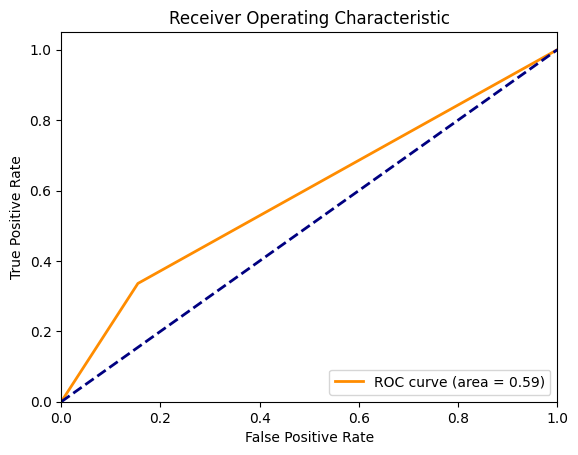

In [327]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

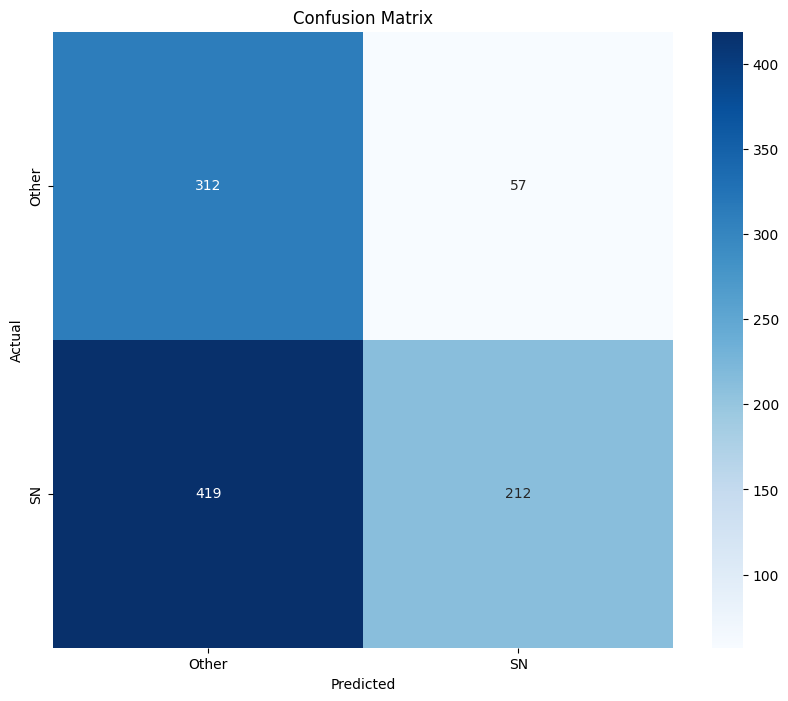

In [328]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Other', 'SN'], yticklabels=['Other', 'SN'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

If you want to validate your model, here's a function that, from the 'data_try' test folder, predicts every alert for every object.

In [331]:
def supernova_classification(test_data_dir, step, num_predictions=None, shuffle=True, verbose=True):
    types_dict = {
        'type_step1': ['Other', 'SN'],
        'type_step2': ['SN I', 'SN II'],
        'type_step3a': ['SN Ia', 'SN Ib/c'],
        'type_step3b': ['SN II', 'SN IIn/b']
    }

    weight_files = {
        'type_step1': 'checkpoints_test/simple_image_V1.weights.h5',
        'type_step2': 'checkpoints/step2_V1.weights.h5',
        'type_step3a': 'checkpoints/step3a_V1.weights.h5',
        'type_step3b': 'checkpoints/step3b_V1.weights.h5'
    }
        
    model.load_weights(weight_files[step])  
      
    obj_id_to_files = predi.group_files_by_obj_id(test_data_dir)

    if step != 'type_step1':
        df_bts_other = pd.read_csv(BTS_PATH)
        df_bts_other = df_bts_other[df_bts_other[step] != 'Other']
        obj_ids = df_bts_other['obj_id'].values
        obj_id_to_files = {obj_id: files for obj_id, files in obj_id_to_files.items() if obj_id in obj_ids}

    if shuffle:
        obj_id_list = list(obj_id_to_files.keys())
        random.shuffle(obj_id_list)
        obj_id_to_files = {obj_id: obj_id_to_files[obj_id] for obj_id in obj_id_list}
    
    all_results = []
    summary_results = []
    types = types_dict[step]
    
    obj_id_list = list(obj_id_to_files.keys())
    if num_predictions is not None:
        obj_id_list = obj_id_list[:num_predictions]

    for obj_id in tqdm(obj_id_list, desc='Obj ID', unit='obj_id'):
        files = obj_id_to_files[obj_id]
        obj_results = []

        photo_df, metadata, _ = PhotometryProcessor.PhotometryProcessor.process_csv(obj_id, df_bts, 'data_kowalski'), *AlertProcessor.AlertProcessor.get_process_alerts(obj_id, 'data_kowalski')
        photo_df, metadata = photo_df.sort_values(by='jd'), metadata.sort_values(by='jd')
        
        metadata['mjd'] = metadata['jd'] - 2400000.5
        metadata = tools.Normalize_mjd(metadata)
        metadata = metadata[metadata['mjd'] < 200]

        data_predictions = DataGeneratorImage(test_data_dir, step=step, batch_size=len(files), shuffle=False, file_list=files)
        

        data, target = data_predictions.__getitem__(0)

        predictions = model.predict(data_predictions, verbose=0)

        for i in range(len(predictions)):
            file = files[i]
            alert_num = int(file.split('_')[-1].split('.')[0])
            obj_results.append({
                'obj_id': obj_id,
                'alert_num': i,
                'mjd': metadata.iloc[alert_num]['mjd'],
                'prediction': predictions[i][0],
                'class_prediction': (predictions[i][0] > 0.5).astype(int),
                'ground_truth': target.numpy()[0]
            })
        
        final_prediction = np.mean([pred['prediction'] for pred in obj_results])
        final_class = (final_prediction > 0.5).astype(int)
        confidence = final_prediction if final_class == 1 else 1 - final_prediction
        ground_truth = obj_results[0]['ground_truth']

        if verbose:
            print(f"Obj ID: {obj_id}")
            print(f"Ground Truth: {types[ground_truth]}")
            print(f"Final Prediction: {types[final_class]}")
            print(f"Confidence: {confidence*100:.2f}%")

        summary_results.append({
            'obj_id': obj_id,
            'ground_truth': types[ground_truth],
            'final_prediction': types[final_class],
            'confidence': confidence * 100
        })
        
        df_obj = pd.DataFrame(obj_results)
        all_results.extend(obj_results)

        if verbose:
            predi.plot_interactive_supernova_classification(df_obj, types)
            predi.plot_interactive_supernova_classification_mjd(df_obj, types)

            max_alert_num = max([res['alert_num'] for res in obj_results])
            plot_data.plot_photometry(obj_id, alerte=None, type_obj=types[ground_truth])

    df_all_results = pd.DataFrame(all_results)
    df_summary_results = pd.DataFrame(summary_results)
    
    return df_all_results, df_summary_results

In [333]:
df_results, df_summary = supernova_classification('data_try', 'type_step1', num_predictions=5, shuffle=True, verbose=True)

Obj ID:   0%|          | 0/5 [00:00<?, ?obj_id/s]

Obj ID: ZTF18adiqgiz
Ground Truth: Other
Final Prediction: SN
Confidence: 50.57%


/data/dev/ml_skyportal/src_dataloader/plot_data.py:203: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Obj ID:  20%|██        | 1/5 [00:01<00:04,  1.20s/obj_id]

Obj ID: ZTF20acsesce
Ground Truth: SN
Final Prediction: Other
Confidence: 54.07%


/data/dev/ml_skyportal/src_dataloader/plot_data.py:203: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Obj ID:  40%|████      | 2/5 [00:02<00:03,  1.18s/obj_id]

Obj ID: ZTF22abyytjo
Ground Truth: Other
Final Prediction: Other
Confidence: 53.50%


Obj ID:  60%|██████    | 3/5 [00:03<00:02,  1.12s/obj_id]

Obj ID: ZTF22abtctzp
Ground Truth: SN
Final Prediction: Other
Confidence: 53.75%


Obj ID:  80%|████████  | 4/5 [00:04<00:01,  1.24s/obj_id]

Obj ID: ZTF20aaukrus
Ground Truth: Other
Final Prediction: Other
Confidence: 55.28%


Obj ID: 100%|██████████| 5/5 [00:05<00:00,  1.01s/obj_id]


As the model has completely overfitted, we can see that it does anything on data (gives 50% every time).

We can also see that although the model is not at all good, its predictions from alert to alert are very similar. This shows that the images don't change too much from alert to alert.
Hence the importance of adding metadata and/or photometry.

This function returns 2 dataframes.

The summary of predictions for each object.

And the results of each alert for each object, allowing you to test other functions that calculate the final prediction and to see more precisely the predictions for each alert.

In [337]:
df_summary 

,obj_id,ground_truth,final_prediction,confidence
0,ZTF18adiqgiz,Other,SN,50.565934
1,ZTF20acsesce,SN,Other,54.071820
2,ZTF22abyytjo,Other,Other,53.504443
3,ZTF22abtctzp,SN,Other,53.748578
4,ZTF20aaukrus,Other,Other,55.275431


In [338]:
df_results

,obj_id,alert_num,mjd,prediction,class_prediction,ground_truth
0,ZTF18adiqgiz,0,37.971192,0.547977,1,0
1,ZTF18adiqgiz,1,46.921296,0.474419,0,0
2,ZTF18adiqgiz,2,48.958391,0.461531,0,0
3,ZTF18adiqgiz,3,52.851493,0.460520,0,0
4,ZTF18adiqgiz,4,58.855718,0.527175,1,0
...,...,...,...,...,...,...
116,ZTF20aaukrus,1,21.025984,0.450164,0,0
117,ZTF20aaukrus,2,23.011192,0.446160,0,0
118,ZTF20aaukrus,3,23.015637,0.436356,0,0
119,ZTF20aaukrus,4,23.019526,0.453928,0,0


now you know how to load data, preprocess data using the functions I've created.
    
I may have made some mistakes or not done things in the best way, so don't hesitate to correct or redo functions if you have good ideas!

Now you can try to train models, look more closely at the data, and try whatever you want.